In [15]:
import numpy as np
import os
import pathlib
import pickle
import skimage
import skimage.io
from skimage.transform import resize as im_resize



In [16]:
outlier_image_path = pathlib.Path('/media/ryan/TOSHIBA EXT/Research/datasets/uhcs-segment/images/spheroidite/annotation-800C-85H-Q-2.png')
outlier_image = skimage.io.imread(outlier_image_path, as_gray=True)

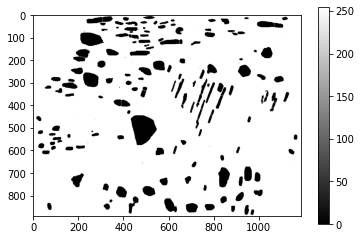

In [17]:
import matplotlib.pyplot as plt
plt.imshow(outlier_image, cmap='gray')
plt.colorbar()

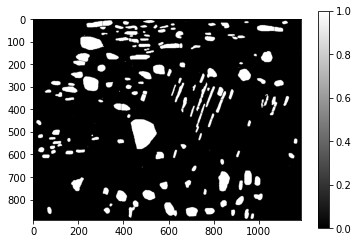

In [18]:
plt.imshow((outlier_image == 0).astype(np.float), cmap='gray')
plt.colorbar()

In [19]:
def load_image_and_annotation(im_path, ann_path):
    """
    Loads image and annotation, resizes annotation, and crops image to get final
    correctly sized images/annotations without extra sem info on bottom of image
    Args:
        im_path: path to image
        ann_path: path to annotation


    returns:
        img: r x c x 3 RGB image
        ann: r x c annotation
        size: (r, c) height, width of the image in pixels
    """
    im_path = pathlib.Path(im_path)
    ann_path = pathlib.Path(ann_path)
    ext_mapper = {'.tiff': 255,
                  '.png': 0}

    ann = (skimage.io.imread(ann_path, as_gray=True) == ext_mapper[ann_path.suffix]).astype(np.float)

    img = skimage.io.imread(im_path, as_gray=True)
    img = skimage.color.gray2rgb(img)

    # image and annotation should have the same width.
    v_scale = img.shape[1]/ann.shape[1]

    new_r = int(ann.shape[0]*v_scale)

    # resize with 0 padding and nearest-neighbor interpolation
    ann = im_resize(ann, (new_r, img.shape[1]), mode='constant', cval=0, order=0)

    img = img[:ann.shape[0], :ann.shape[1], ...]
    assert img.shape[:2] == ann.shape
    return img, ann, ann.shape

In [20]:
data_root = pathlib.Path('/media/ryan/TOSHIBA EXT/Research/datasets/uhcs-segment/images/spheroidite/')
with open(pathlib.Path(data_root, 'spheroidite-files.pickle'), 'rb') as f:
    filename_subset = sorted(pickle.load(f))

image_paths = {x.stem.replace('micrograph-','') : x for x in data_root.glob('micrograph*')}
annotation_paths = {x.stem.replace('annotation-','') : x for x in data_root.glob('annotation*')}

image_subset = [image_paths.get(x) for x in filename_subset if image_paths.get(x) is not None]
annotation_subset = [annotation_paths.get(x) for x in filename_subset if annotation_paths.get(x) is not None]


In [21]:
process = False # if true, batch processes the images
if process:
    processed_img_dir = pathlib.Path('..','data','raw','spheroidite-images')
    os.makedirs(processed_img_dir, exist_ok=True)

    for ipath, apath in zip(image_subset, annotation_subset):
        img, ann, size = load_image_and_annotation(ipath, apath)

        size_str = '_sizeRC_{}_{}.png'.format(*size)
        ipath_new = pathlib.Path(processed_img_dir, ipath.stem+size_str)
        apath_new = pathlib.Path(processed_img_dir, apath.stem+size_str)

        for im, im_path in zip([img, ann], [ipath_new, apath_new]):
            skimage.io.imsave(im_path, im)
